# Example 3: Dark Matter

In this example we'll consider a more scientifically motivated problem. Astrophysically, dark matter is observed to fall into spherically symmetric arrangements called "haloes". As a function of spherical radius $r$, the density profile of a halo is typically taken to be the Navarro-Frenk-White (NFW) profile:

$$\rho(r) = \dfrac{\rho_0}{\dfrac{r}{r_s}\left(1 + \dfrac{r}{r_s}\right)^2}$$

This is a 2-parameter profile, with a density scaling $\rho_0$ serving as a normalisation, and a scale radius $r_s$. This is essentially double power law: $\rho \propto r^{-1}$ where $r \ll r_s$ and $\rho \propto r^{-3}$ where $r \gg r_s$.

For the Milky Way, reasonable values are $\rho_0 \approx 4 \times 10^{-22}~\mathrm{kg/m^3} \approx 0.006~\mathrm{M}_\odot / \mathrm{pc}^3$ and $r_s \approx 6 \times 10^{20}~\mathrm{m}\approx 20~\mathrm{kpc}$. We don't need to worry so much about $\rho_0$ as it simply sets the overall normalisation. 

In our case, we'll place 2 such haloes in a 3D box and sample some dark matter particles.

It's worth noting that the mass of the NFW profile is divergent unless cut off at some radius. The choice of this radius is a slightly thorny issue, but we'll just say that the density cuts to zero at $10 r_s$.

## Python preamble

Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

Matplotlib style file

In [2]:
plt.style.use('figstyle.mplstyle')

Set up RNG (this is optional, but it makes results reproducible)

In [3]:
rng = np.random.default_rng(42)

## NFW density

Function to evaluate density as function of position and halo parameters. A thing  to note here is the `q + 1e-3` in the denominator of the density, which didn't appear in the equation above. This is a way to deal with the divergence at $r=0$: this way when $r \ll r_s$, the density approaches a constant $\rho \rightarrow \rho(r=10^{-3}r_s)$.

In [4]:
def NFW_density(X, rho_0, r_s):
    r = np.linalg.norm(X, axis=-1)
    q = r / r_s
    rho = rho_0 / ((q + 1e-3) * (1 + q)**2)
    m = q > 10
    if np.any(m==True): rho[m] = 0
    return rho

## Creating halo points with `LintSampler`

In [5]:
from lintsampler import LintSampler

Let's do two haloes at different locations, both with scale radii of 0.5 (we could call the units kpc, but really the code is agnostic), but with differing values of $\rho_0$. As it just sets a normalisation, we don't actually need to worry about the precise value of $\rho_0$, only the relative values between the two haloes. The total halo mass is proportional to $\rho_0$, so we'll give one halo twice the $\rho_0$ of the other and recheck later that it got twice the particles.

First, we prepare the pdf, including setting the parameters for each halo:

In [6]:
def two_halo_pdf(X,centres, rho_0s, scale_radii): 
    return np.sum([NFW_density(X-centres[h], rho_0s[h], scale_radii[h]) for h in range(0,len(centres))],axis=0)
    
centres = [np.array([0.5, -2.5, 3.0]),np.array([-2.5, -2.0, -5.5])]
rho_0s = [1.0,2.0]
scale_radii = [0.5,0.5]


Next, we set up the grid we want to sample on:

In [7]:
# grid sizes: outer grid is 128^3, but central 32^3 replaced with 128^3
N_grid = 128

# set up grid boundaries
h = 15
Xedges = np.linspace(-h, h, N_grid + 1)


And set up the sampling instance:

In [8]:
L = LintSampler((Xedges,Xedges,Xedges),pdf=two_halo_pdf,vectorizedpdf=True,pdf_args=(centres,rho_0s,scale_radii))

Lastly, draw the samples.

In [10]:
X = L.sample(N=1000000)



To visualise, we'll first make a histogram as in previous examples:

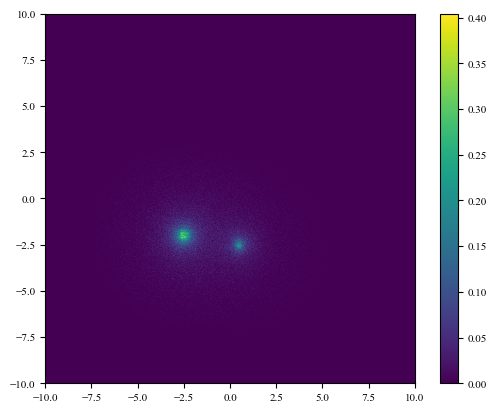

In [11]:
plt.hist2d(X[:, 0], X[:, 1], bins=np.linspace(-10, 10, 1000), density=True)
plt.gca().set_aspect('equal', adjustable='box')

plt.colorbar();

This doesn't look particularly impressive. The thing is that power law functions like the NFW profile have a vast dynamic range, so plotting density in linear space will show you the peak and not much else. Let's instead use a log-scale colour map:

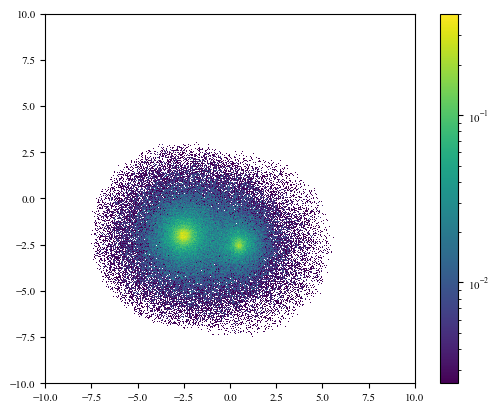

In [12]:
plt.hist2d(X[:, 0], X[:, 1], bins=np.linspace(-10, 10, 1000), density=True, norm=LogNorm())
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar();

We can see now that the haloes appear to overlap considerably, at least in $x$ and $y$. However, if we choose a different projection, e.g. $x-z$:

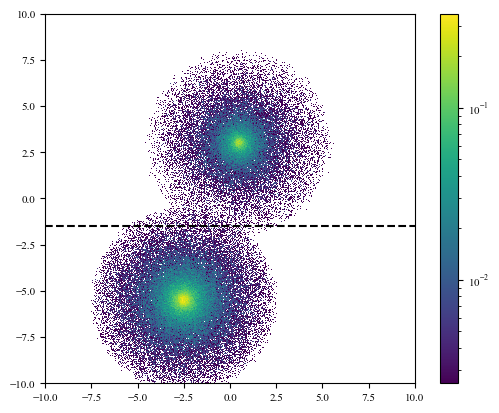

In [13]:
plt.hist2d(X[:, 0], X[:, 2], bins=np.linspace(-10, 10, 1000), density=True, norm=LogNorm())
plt.plot([-10, 10], [-1.5, -1.5], c='k', ls='dashed')
plt.xlim(-10, 10)
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar();

Still some overlap, but overall the haloes seem to separate much more cleanly in $z$. We can use this to test whether an appropriate number of particles has been sampled in each halo. The lower halo in this plot has twice the mass of the upper halo (because its $\rho_0$ parameter was doubled), so it should have twice the particles. If we take a horizontal line at $z=-1.25$ (the dashed line in the plot), then virtually all of the particles above/below the line will belong to the upper/lower halo (with some cross-contamination).

In [15]:
m = X[:, 2] > -1.25
print(f"Upper halo fraction: {m.sum() / len(m): .3f}")
print(f"Lower halo fraction: {1 - m.sum() / len(m): .3f}")

Upper halo fraction:  0.336
Lower halo fraction:  0.664


Looks great!